# SENTIMENT ANALYSIS

In [1]:
## By Fomekong Tchoffo Frank Borel

In [450]:
import pandas as pd
import glob
import time
import re
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.layers import SimpleRNN,Conv1D,Conv2D, Flatten, MaxPooling2D, Dropout,MaxPooling1D,GlobalMaxPooling1D,GRU,Bidirectional

from keras.models import Sequential,Model
from keras.layers import Dense, Embedding, LSTM
import numpy as np

import tensorflow as tf
from sklearn import metrics


from nltk.stem.porter import PorterStemmer

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


## Plot

In [451]:
import matplotlib.pyplot as plt

In [452]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [453]:
def plot_results(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
 
    plt.title('Training and validation Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation Loss')
    plt.legend()
    plt.show()

## Load Data

In [454]:
def Load_data(path1,out_name):
    '''Here we represent data like this negative is 0
        and positive is 1
    '''
    paths=path1
    datas={"comment":[],"label":[]}
    file_listpos=glob.glob(paths+"/pos/*.txt")
    file_listneg=glob.glob(paths+"/neg/*.txt")
    for file in file_listpos:
        file=open(file,"r")
        p=file.read()
        datas["comment"].append(p)
        datas["label"].append(1)
        file.close()
    for file in file_listneg:
        file=open(file,"r")
        p=file.read()
        datas["comment"].append(p)
        datas["label"].append(0)
        file.close()
    df=pd.DataFrame.from_dict(datas)
#     print(df)
    df.to_csv("./"+str(out_name)+".csv", index=False)

### Load Test Data

In [186]:
start = time.perf_counter()
Load_data("./aclImdb/test","test")
end = time.perf_counter()
print("\n==============================================================")
print("All Treatment took : ", round(end - start, 2), 'seconds')
print("==============================================================")


All Treatment took :  0.0 seconds


### Load Unsup

In [187]:
paths="./unsup"
datas={"comment":[]}
file_listpos=glob.glob(paths+"/*.txt")
for file in file_listpos:
    file=open(file,"r",encoding="utf8")
    p=file.read()
    datas["comment"].append(p)
    file.close()
df=pd.DataFrame.from_dict(datas)
#     print(df)
df.to_csv("./unsup"+".csv", index=False)

In [470]:
unsup_data=pd.read_csv('unsup.csv')
unsup_data.head(10)

,comment
0,"I admit, the great majority of films released ..."
1,"Take a low budget, inexperienced actors doubli..."
2,"Everybody has seen 'Back To The Future,' right..."
3,Doris Day was an icon of beauty in singing and...
4,"After a series of silly, fun-loving movies, 19..."
5,"This isn't exactly a musical, but it almost se..."
6,After seven years and seventeen pictures at Wa...
7,In the 1950's there were many film boigraphies...
8,MY RATING- 7.3<br /><br />This one is a curiou...
9,Doris Day and James Cagney are excellent in th...


In [456]:
unsup_data.shape

(50000, 1)

#### Some Test data

In [473]:
test_data=pd.read_csv("test.csv",encoding="latin")
test_data.head(100)

,comment,label
0,We have moved far beyond this tentative foray ...,1
1,"Rififi, directed by Jules Dassin, is in line w...",1
2,...that maybe someday people will wake up to. ...,1
3,I've seen this movie more than once and it's w...,1
4,The young John Garfield turned in a fine perfo...,1
...,...,...
95,"I am a massive Hitchcock fan, ever since seein...",1
96,Yes!! They finally got it down to perfection. ...,1
97,I had the good fortune to be at Perris Island ...,1
98,This is definitely the biggest surprise of the...,1


#### Test Size

In [458]:
test_data.shape

(25000, 2)

### Load Train Data

In [27]:
start = time.perf_counter()
Load_data("./aclImdb/train","train")
end = time.perf_counter()
print("\n==============================================================")
print("All Treatment took : ", round(end - start, 2), 'seconds')
print("==============================================================")


All Treatment took :  79.4 seconds


#### Some  Train Data

In [472]:
train_data=pd.read_csv("train.csv",encoding="latin")
train_data.head(100)

,comment,label
0,The combination of reading the Novella and vie...,1
1,I watched the presentation of this on PBS in t...,1
2,Having to have someone hold your hand whenever...,1
3,I really enjoyed this movie. It succeeded in d...,1
4,"Watching ""Ossessione"" today -- more than 6 dec...",1
...,...,...
95,"The story of a drifter, his sheep ranch boss, ...",1
96,"""The Shop Around the Corner"" is one of the gre...",1
97,"By God, it's been a long time since I saw this...",1
98,"The Flock is unjustly maligned as a lesser ""Se...",1


#### Train Size

In [460]:
train_data.shape

(25000, 2)

### Preprocessing Data

In [468]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = remove_between_square_brackets(text)
    return text

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Removing html tag
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def preprocess_data(data):
    data['comment'] = data['comment'].apply(cleanhtml)
    data['comment'] = data['comment'].apply(lambda x: x.lower()) # change all text to lower
    data['comment'] = data['comment'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    data['comment'] = data['comment'].apply(remove_between_square_brackets)
    data['comment'] = data['comment'].apply(denoise_text)
    data['comment'] = data['comment'].apply(simple_stemmer)
    return data

### On Unsupervised data

In [471]:
unsup_data=preprocess_data(unsup_data)
unsup_data.head(10)

,comment
0,i admit the great major of film releas befor s...
1,take a low budget inexperienc actor doubl as p...
2,everybodi ha seen back to the futur right whet...
3,dori day wa an icon of beauti in sing and act ...
4,after a seri of silli funlov movi 1955 wa a bi...
5,thi isnt exactli a music but it almost seem li...
6,after seven year and seventeen pictur at warne...
7,in the 1950 there were mani film boigraphi for...
8,my rate 73thi one is a curiou mov made when ja...
9,dori day and jame cagney are excel in thi lush...


#### On Train Data

In [474]:
train_data=preprocess_data(train_data)
train_data.head(10)

,comment,label
0,the combin of read the novella and view thi fi...,1
1,i watch the present of thi on pb in the us whe...,1
2,have to have someon hold your hand whenev walk...,1
3,i realli enjoy thi movi it succeed in do somet...,1
4,watch ossession today more than 6 decad later ...,1
5,ani one who ha seen mel gibson the passion of ...,1
6,let me say first that thi show wa top tier whe...,1
7,the notori betti page 2006 12 gretchen mol lil...,1
8,as someon who live near buffalo new york thi m...,1
9,i bought the video rather late in my collect a...,1


#### On test Data

In [475]:
test_data=preprocess_data(test_data)
test_data.head(10)

,comment,label
0,we have move far beyond thi tent foray into a ...,1
1,rififi direct by jule dassin is in line with t...,1
2,that mayb someday peopl will wake up to peopl ...,1
3,ive seen thi movi more than onc and it worth i...,1
4,the young john garfield turn in a fine perform...,1
5,if you like paddi chayevski network youll prob...,1
6,i agre with andi thi is a good movi kevin mcki...,1
7,great movi good act a wonder script it excit t...,1
8,the famili happi is crumbl when the from the b...,1
9,the murder in opera are not actual murder as m...,1


In [476]:
train_data["label"].value_counts()

1    12500
0    12500
Name: label, dtype: int64

## Tokenization

### Tokenizer Generator

In [477]:
def tokengen(maxword=100):
    return Tokenizer(num_words=maxword,lower=True, split=" ")

In [478]:
max_features = 5000
maxlength = 500
data=np.concatenate((train_data['comment'].values,unsup_data['comment'].values))
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train_data['comment'].values)
X = tokenizer.texts_to_sequences(train_data['comment'].values)


# pad sequences
X = pad_sequences(X, maxlen=maxlength)
X.shape

(25000, 500)

In [446]:
Y=pd.get_dummies(train_data.label).values
print(Y)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [479]:
X_test = tokenizer.texts_to_sequences(test_data['comment'].values)
X_test = pad_sequences(X_test, maxlen=maxlength)
Y_test=pd.get_dummies(test_data.label).values

## Model LSTM

In [480]:
embed_dim = 128
hidden_units = 100
n_classes = 2

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(LSTM(hidden_units))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 500, 128)          640000    
                                                                 
 lstm_9 (LSTM)               (None, 100)               91600     
                                                                 
 dense_103 (Dense)           (None, 2)                 202       
                                                                 
Total params: 731,802
Trainable params: 731,802
Non-trainable params: 0
_________________________________________________________________
None


### Fit Model

In [481]:
start = time.perf_counter()
historyA=model.fit(X, Y, batch_size = 100, epochs=10, validation_split=0.2)
end = time.perf_counter()
print("\n==============================================================")
print("All Treatment took : ", round(end - start, 2), 'seconds')
print("==============================================================")

Epoch 1/10
200/200 [==============================] - 178s 884ms/step - loss: 0.4619 - accuracy: 0.7729 - val_loss: 0.6744 - val_accuracy: 0.7054
Epoch 2/10
200/200 [==============================] - 176s 879ms/step - loss: 0.2775 - accuracy: 0.8906 - val_loss: 0.3917 - val_accuracy: 0.8484
Epoch 3/10
200/200 [==============================] - 176s 883ms/step - loss: 0.2203 - accuracy: 0.9154 - val_loss: 0.4951 - val_accuracy: 0.7978
Epoch 4/10
200/200 [==============================] - 176s 881ms/step - loss: 0.1698 - accuracy: 0.9375 - val_loss: 0.4690 - val_accuracy: 0.8430
Epoch 5/10
200/200 [==============================] - 176s 879ms/step - loss: 0.1363 - accuracy: 0.9495 - val_loss: 0.4579 - val_accuracy: 0.8518
Epoch 6/10
200/200 [==============================] - 176s 878ms/step - loss: 0.1078 - accuracy: 0.9615 - val_loss: 0.4135 - val_accuracy: 0.8726
Epoch 7/10
200/200 [==============================] - 175s 877ms/step - loss: 0.1649 - accuracy: 0.9365 - val_loss: 0.7351 -

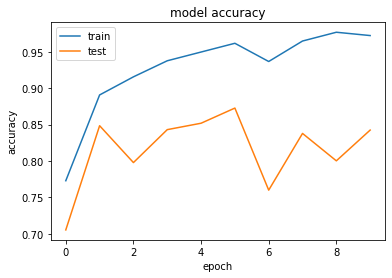

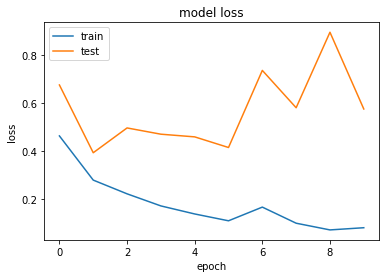

In [482]:
plt.plot(historyA.history['accuracy'])
plt.plot(historyA.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(historyA.history['loss'])
plt.plot(historyA.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### test model LSTM

In [483]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5576701760292053
Test accuracy: 0.8344799876213074


### Save model and Tokenizer

In [484]:
model.save('trained_model_LSTM3.h5')

with open('trained_tokenizer113.pkl', 'wb') as f: # creates a pickle file 'trained_tokenizer.pkl'
    pickle.dump(tokenizer, f)

## Model CNN

In [485]:
epochs = 10
maxlen = 500
embedding_dim = 50
num_filters = 64
kernel_size = 5
batch_size = 32

In [486]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data)
X_train = tokenizer.texts_to_sequences(train_data['comment'])
X_test = tokenizer.texts_to_sequences(test_data['comment'])
vocab_size = len(tokenizer.word_index) + 1 

In [487]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [488]:
num_classes = 2
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2.add(Conv1D(num_filters, kernel_size, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, 500, 50)           12340250  
                                                                 
 conv1d_11 (Conv1D)          (None, 496, 64)           16064     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_104 (Dense)           (None, 10)                650       
                                                                 
 dense_105 (Dense)           (None, 1)                 11        
                                                                 
Total params: 12,356,975
Trainable params: 12,356,975
Non-trainable params: 0
_________________________________________

In [489]:
Y=train_data['label'].values
Y_test=test_data['label'].values

In [490]:

hist=model2.fit(X_train, Y,epochs=epochs,verbose=True,validation_data=(X_test, Y_test),batch_size=batch_size)

Epoch 1/10
782/782 [==============================] - 64s 81ms/step - loss: 0.4081 - accuracy: 0.8107 - val_loss: 0.2914 - val_accuracy: 0.8745
Epoch 2/10
782/782 [==============================] - 63s 81ms/step - loss: 0.2100 - accuracy: 0.9159 - val_loss: 0.2682 - val_accuracy: 0.8906
Epoch 3/10
782/782 [==============================] - 64s 81ms/step - loss: 0.1090 - accuracy: 0.9640 - val_loss: 0.2962 - val_accuracy: 0.8867
Epoch 4/10
782/782 [==============================] - 64s 82ms/step - loss: 0.0396 - accuracy: 0.9918 - val_loss: 0.3441 - val_accuracy: 0.8860
Epoch 5/10
782/782 [==============================] - 64s 81ms/step - loss: 0.0105 - accuracy: 0.9991 - val_loss: 0.4058 - val_accuracy: 0.8847
Epoch 6/10
782/782 [==============================] - 64s 81ms/step - loss: 0.0036 - accuracy: 0.9998 - val_loss: 0.4450 - val_accuracy: 0.8848
Epoch 7/10
782/782 [==============================] - 64s 81ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.4772 - val_accuracy:

In [491]:
loss, accuracy = model2.evaluate(X_train, Y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Training Accuracy: 1.0000
Testing Accuracy:  0.8865
Testing Loss:  0.5542


### Score CNN

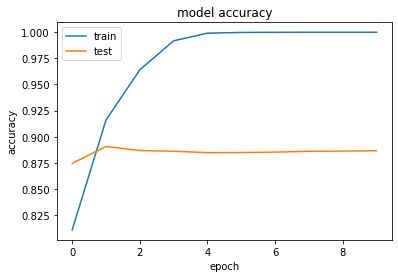

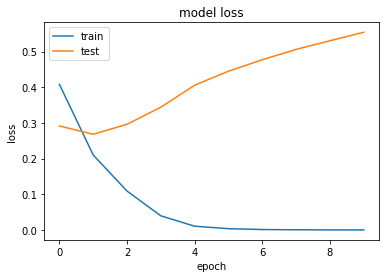

In [492]:
historyA=hist
plt.plot(historyA.history['accuracy'])
plt.plot(historyA.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(historyA.history['loss'])
plt.plot(historyA.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save CNN

In [493]:
model2.save('trained_model_CNN1.h5')

with open('trained_tokenizer_CNN1.pkl', 'wb') as f: # creates a pickle file 'trained_tokenizer.pkl'
    pickle.dump(tokenizer, f)

## Model RNN

In [494]:
max_features = 10000
maxlen = 1000

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data)
X_train = tokenizer.texts_to_sequences(train_data['comment'])
X_test = tokenizer.texts_to_sequences(test_data['comment'])
vocab_size = len(tokenizer.word_index) + 1 

train_data1 = sequence.pad_sequences(X_train, maxlen=maxlen)
test_data1 = sequence.pad_sequences(X_test, maxlen=maxlen)
 

In [495]:
model3 = Sequential()
model3.add(Embedding(max_features, 32))
model3.add(SimpleRNN(32))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
 
model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
 


In [496]:
history = model3.fit(train_data1, Y,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)
 

Epoch 1/10
157/157 [==============================] - 27s 170ms/step - loss: 0.5809 - acc: 0.6966 - val_loss: 0.8223 - val_acc: 0.5760
Epoch 2/10
157/157 [==============================] - 26s 168ms/step - loss: 0.3674 - acc: 0.8439 - val_loss: 0.5051 - val_acc: 0.8044
Epoch 3/10
157/157 [==============================] - 27s 169ms/step - loss: 0.2895 - acc: 0.8856 - val_loss: 0.4994 - val_acc: 0.7740
Epoch 4/10
157/157 [==============================] - 27s 170ms/step - loss: 0.2203 - acc: 0.9136 - val_loss: 0.6738 - val_acc: 0.7536
Epoch 5/10
157/157 [==============================] - 27s 169ms/step - loss: 0.1486 - acc: 0.9460 - val_loss: 0.5281 - val_acc: 0.7972
Epoch 6/10
157/157 [==============================] - 26s 168ms/step - loss: 0.0887 - acc: 0.9706 - val_loss: 0.7503 - val_acc: 0.7956
Epoch 7/10
157/157 [==============================] - 26s 168ms/step - loss: 0.0511 - acc: 0.9829 - val_loss: 1.2499 - val_acc: 0.7742
Epoch 8/10
157/157 [==============================] - 2

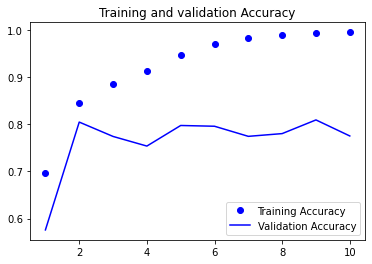

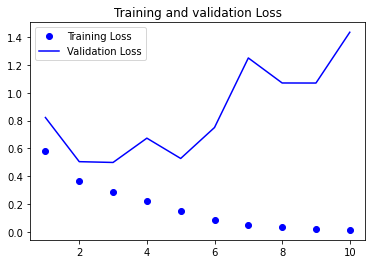

In [497]:
plot_results(history)

In [498]:
score = model3.evaluate(test_data1, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1084270477294922
Test accuracy: 0.8089600205421448


In [499]:
model3.save('trained_model_RNN3.h5')

with open('trained_tokenizer_RNN3.pkl', 'wb') as f: # creates a pickle file 'trained_tokenizer.pkl'
    pickle.dump(tokenizer, f)

## MLOP

In [408]:
import gradio as gr

ContextualVersionConflict: (anyio 2.2.0 (c:\users\remen\anaconda3\lib\site-packages), Requirement.parse('anyio<5,>=3.4.0'), {'starlette'})

In [500]:
#create a function to make predictions
#return a dictionary of labels and probabilities
def positive_or_negative(text):
    text=text.lower()# change all text to lower
    data = re.sub('[^a-zA-z0-9\s]','',text)
    data=tokenizer.texts_to_sequences([data])
    data = pad_sequences(data, padding='post', maxlen=500)
    prediction = model2.predict(data).tolist()[0]
    class_names = ["Positive", "Negative"]
    return {class_names[i]: prediction[i] for i in range(1)}
print(positive_or_negative('i am not ok with this'))

#setup the interface
iface = gr.Interface(
    fn = positive_or_negative, 
    inputs = "text", 
    outputs = gr.outputs.Label(),
)
iface.launch(share=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
{'Positive': 1.395985145791201e-05}


NameError: name 'gr' is not defined